In [5]:
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, gluon, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

In [6]:
#多项式拟合实验
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = nd.random.normal(shape=(n_train + n_test, 1)) # 200*1
poly_features = nd.concat(features, nd.power(features, 2),
                          nd.power(features, 3))
# 按公式计算
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
         + true_w[2] *poly_features[:, 2] + true_b)
# 添加噪声
labels += nd.random.normal(scale=0.1, shape=labels.shape)

In [7]:
#前两个样本
features[:2],poly_features[:2],labels[:2]

(
 [[1.1630785]
  [0.4838046]]
 <NDArray 2x1 @cpu(0)>, 
 [[1.1630785  1.3527517  1.5733565 ]
  [0.4838046  0.2340669  0.11324265]]
 <NDArray 2x3 @cpu(0)>, 
 [10.534649  5.530093]
 <NDArray 2 @cpu(0)>)

In [8]:
# 定义，训练，测试模型
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

In [9]:
num_epochs, loss = 100, gloss.L2Loss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': 0.01})
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(loss(net(train_features),
                             train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features),
                            test_labels).mean().asscalar())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net[0].weight.data().asnumpy(),
          '\nbias:', net[0].bias.data().asnumpy())

final epoch: train loss 0.0070935446 test loss 0.0064219665
weight: [[ 1.1717567 -3.3910124  5.60115  ]] 
bias: [4.9858127]


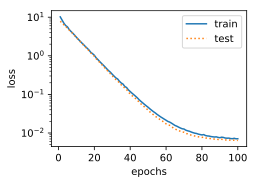

In [10]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :],
            labels[:n_train], labels[n_train:])

final epoch: train loss 159.33383 test loss 102.62764
weight: [[22.617666]] 
bias: [-0.62726814]


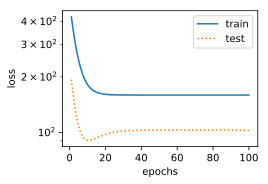

In [11]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train],
             labels[n_train:]) # 线性函数，欠拟合

final epoch: train loss 0.47576833 test loss 133.27454
weight: [[2.0588458 1.9273669 2.0477402]] 
bias: [2.482129]


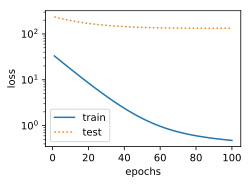

In [12]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2],
             labels[n_train:]) # 训练样本不足，过拟合：模型的训练误差远小于它在测试数据集上的误差。